# Feature Engineering - By Foivos Gaitantzis

#### This section of the program is dedicated for Headline Cleaning & Sentiment Analysis of News Articles, Sentiment Bias Visualization, Seperation of Sentiment for each Source,  Mean Sentiment Aggregation for each Date Range, Merging of Sentiment with Historical Stock Data, Filling in NaN values with Median Values for Sentiment / Interpolation of Previous Values for Historical Stock Data, Insertion of Predicted Labels to use in Training, Calculation of Technical Indicators (RSI & MACD) and Extraction to CSV File.

### Load the Libraries

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import datetime
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

#Download the Default Vader Sentiment Lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Fivos
[nltk_data]     Gaitantzis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Define the Feature Engineering Parameters & Utility Functions

In [23]:
#Set the Start Date
start_month = 1
start_day = 1
start_year = 2016

#Set the End Date
end_month = 12
end_day = 31
end_year = 2018

#Set the filename
filename = 'aapl'

#Set the forecast horizon (to predict 'how many days' ahead)
forecast_horizon = 1

In [24]:
#Utility Function: Get the date range between two dates
def daterange(start, end):
    for i in range((end - start).days + 1):
        yield (start + datetime.timedelta(i))
        
#Initiate the VADER Sentiment Analyzer
VaderAnalyzer = SentimentIntensityAnalyzer()

#Utility function: Caclculate the sentiment score for a given Headline
def sentimentScore(Headline):
    results = []
    for sentence in Headline:
        score = VaderAnalyzer.polarity_scores(sentence)
        results.append(score)
    return results
        
#Define the two dates in datetime format
start_date = datetime.date(year = start_year, month = start_month, day = start_day)
end_date = datetime.date(year = end_year, month = end_month, day = end_day)

#Define the Final Sentiment Lexicon
Final_Lexicon = {}

#Import: Oliveira, Nuno, Paulo Cortez, and Nelson Areal. "Stock market sentiment lexicon acquisition using microblogging data and statistical measures." Decision Support Systems 85 (2016): 62-73.
Stock_Lexicon = pd.read_csv('include/stock_lex.csv')
Stock_Lexicon['Sentiment'] = (Stock_Lexicon['Aff_Score'] + Stock_Lexicon['Neg_Score']) / 2
Stock_Lexicon = dict(zip(Stock_Lexicon['Item'], Stock_Lexicon['Sentiment']))
Stock_Lexicon = {i:v for i, v in Stock_Lexicon.items() if len(i.split(' ')) == 1}
for i, v in Stock_Lexicon.items():
    if v > 0:
        Final_Lexicon.update({i: v / max(Stock_Lexicon.values()) * 4})
    else:
        Final_Lexicon.update({i: v / min(Stock_Lexicon.values()) * -4})

#Import: Loughran and McDonald Sentiment Word Lists https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists
Positive_Words = pd.read_csv('include/positive.csv', header=None)
for row in Positive_Words[0]:
    Final_Lexicon.update({row.lower(): 2})
    
Negative_Words = pd.read_csv('include/negative.csv', header=None)
for row in Negative_Words[0]:
    Final_Lexicon.update({row.lower(): -2})

#Update the Vader Lexicon to Include the Imported Lexicons
Final_Lexicon.update(VaderAnalyzer.lexicon)
VaderAnalyzer.lexicon = Final_Lexicon

### Headline Cleaning & Sentiment Analysis

In [25]:
#Load all News
News = pd.read_csv('files/'+filename+'_News_All.csv')

#Headline Cleaning
News['Headline'] = News['Headline'].str.lower() #Make all text lowercase
News['Headline'] = News['Headline'].str.replace(r'[^\w\s]+', '') #Remove punctuation

#Retrieve Sentiment for each Headline and Merge with News Dataframe
SentimentResults = pd.DataFrame(sentimentScore(News['Headline']))
News = pd.merge(News, SentimentResults, left_index=True, right_index=True)

#Get rid of Sentiment Columns['neg', 'pos', 'neu'] & keep ['compound']
del News['neg']
del News['pos']
del News['neu']

#Get rid of all Neutral Articles
News.drop(News[ (News['compound'] >= -0.05) & (News['compound'] <= 0.05) ].index , inplace=True)

#Set Sentiment Class to Positive if compound > 0 and to Negative if compound < 0
News['Sentiment'] = News['compound'].apply(lambda x: "Positive" if x > 0 else "Negative")

### Sentiment Bias Visualization

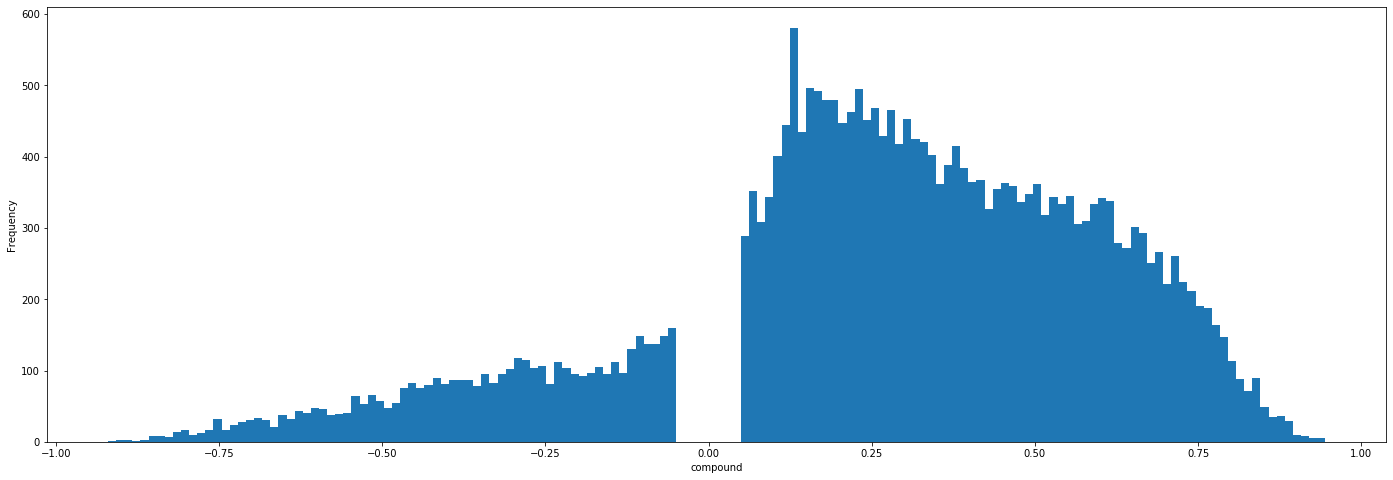

In [26]:
plt.figure(figsize = (24, 8))
plt.hist(News['compound'], bins = 150)
plt.xlabel('compound')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Frequency')

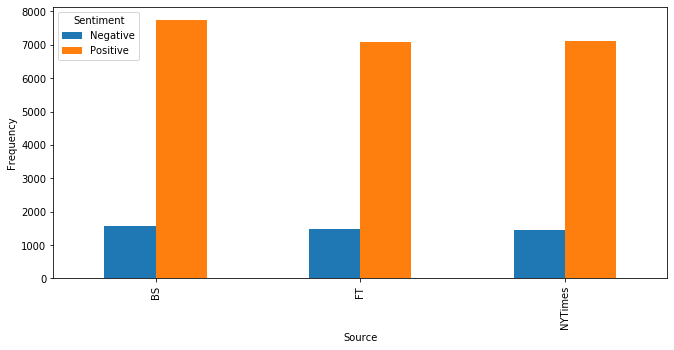

In [27]:
#Create a bar graph that counts headlines depending on their Source and Sentiment Class
News.groupby(['Source', 'Sentiment']).size().unstack().plot(kind='bar',figsize=(11, 5))
plt.ylabel('Frequency')

Negative Sentiment News: 4518
Positive Sentiment News: 21945
Total News: 26463

Common Words between Articles with Negative Sentiment:


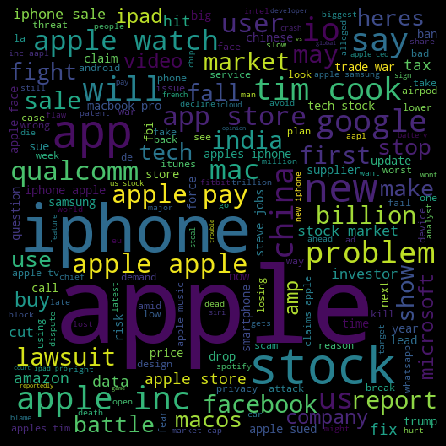

In [28]:
#Count the total Number of News in Each Class & The sum of both
print("Negative Sentiment News: "+str(News[News['compound'] < 0]['Headline'].count()))
print("Positive Sentiment News: "+str(News[News['compound'] > 0]['Headline'].count()))
print("Total News: "+str(News['Headline'].count()))

#Generate a WordCloud that shows Common Keywords in Headlines for Articles that Belong in the Negative Sentiment Class
print("\nCommon Words between Articles with Negative Sentiment:")
headline_text = ' '.join(list(News[News['compound'] < 0]['Headline']))
headline_wc = WordCloud(width=512, height=512).generate(headline_text)
#Plot the WordCloud
plt.figure(figsize = (8, 6), facecolor = 'k')
plt.imshow(headline_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### Seperation of Sentiment for each Source & Mean Sentiment Aggregation for each Date Range

In [29]:
#Set a new Compound column for each Source
News['compoundFT'] = News['compound'][News['Source'] == 'FT']
News['compoundNYTimes'] = News['compound'][News['Source'] == 'NYTimes']
News['compoundBS'] = News['compound'][News['Source'] == 'BS']

#Delete the old compound column
del News['compound']

#Group the Dataframe by Date taking the mean OF every Sentiment Value per day
News_Mean = (News.groupby(['Date']).mean())
News_Mean.index = pd.to_datetime(News_Mean.index, format='%Y/%m/%d')

News_Mean = News_Mean[['compoundFT', 'compoundNYTimes', 'compoundBS']]

#Display the first 5 rows of the Dataframe
News_Mean.head()

,compoundFT,compoundNYTimes,compoundBS
Date,,,
2016-01-01,0.188000,0.424900,0.361980
2016-01-02,-0.292075,0.301267,NaN
2016-01-03,0.434133,0.371400,NaN
2016-01-04,0.187520,0.267025,0.211217
2016-01-05,0.097792,0.116489,0.236300


In [30]:
#Import the Historical Stock Data
Stock_Data = pd.read_csv('files/'+filename+'_Stock_Data.csv')

#Set the Data Column as Index Column
Stock_Data = Stock_Data.set_index('Date')

#Set the Index Column Type to Datetime
Stock_Data.index = pd.to_datetime(Stock_Data.index, format='%Y-%m-%d')

#Display the first 5 rows of the Dataframe
Stock_Data.head()

,Close,Volume,Adj Close
Date,,,
2016-01-04,105.349998,67649400,98.213585
2016-01-05,102.709999,55791000,95.752419
2016-01-06,100.699997,68457400,93.878586
2016-01-07,96.449997,81094400,89.916473
2016-01-08,96.959999,70798000,90.391907


### Merging of Sentiment with Historical Stock Data, Filling in NaN values with Median Values for Sentiment / Interpolation of Previous Values for Historical Stock Data & Insertion of Predicted Labels to use in Training

In [31]:
#Create a list of all Dates between the Start and End Date & Set Date Column to Index (& Datetime)
Dates = pd.DataFrame(list(daterange(start_date, end_date)), columns=["Date"]).set_index('Date')
Dates.index = pd.to_datetime(Dates.index, format='%Y-%m-%d')

#Merge all 3 Dataframes (List of all Dates / News Mean Sentiment Values per Day / Historical Stock Data)
Data = pd.concat([Dates, News_Mean, Stock_Data], axis=1, sort=False)

#Set NaN values for Sentiment to be the Mean
Data['compoundFT'].fillna(Data['compoundFT'].mean(), inplace=True)
Data['compoundNYTimes'].fillna(Data['compoundNYTimes'].mean(), inplace=True)
Data['compoundBS'].fillna(Data['compoundBS'].mean(), inplace=True)

#Interpolation of previous Historical Values for NaN values
Data[[ "Close", "Volume", "Adj Close" ]] = \
Data[[ "Close", "Volume", "Adj Close" ]] \
.interpolate(method='linear', limit_direction='forward', axis=0)

#Set the Label for the Predicted Column to be the next Days Close Price
Data['Predicted Adj Close'] = Data['Adj Close'].shift(-forecast_horizon)

#Display the first 5 rows of the Dataframe
Data.head()

,compoundFT,compoundNYTimes,compoundBS,Close,Volume,Adj Close,Predicted Adj Close
Date,,,,,,,
2016-01-01,0.188000,0.424900,0.361980,NaN,NaN,NaN,NaN
2016-01-02,-0.292075,0.301267,0.271368,NaN,NaN,NaN,NaN
2016-01-03,0.434133,0.371400,0.271368,NaN,NaN,NaN,98.213585
2016-01-04,0.187520,0.267025,0.211217,105.349998,67649400.0,98.213585,95.752419
2016-01-05,0.097792,0.116489,0.236300,102.709999,55791000.0,95.752419,93.878586


### Calculation of Technical Indicators (RSI & MACD) and Extraction to CSV File

In [32]:
# ---- MACD ---- #

#Calculate the Exponential Moving Average for a span of 26 and a span of 12 days
Data['26 EMA'] = Data['Adj Close'].ewm(span=26).mean() 
Data['12 EMA'] = Data['Adj Close'].ewm(span=12).mean() 
#Calculate the MACD by taking the EMA for 26 days and subtracting it from the EMA for 12 days
Data['MACD'] = Data['12 EMA'] - Data['26 EMA']

# ---- RSI ---- #

#Calculate the Change between Closing Prices per day
Data['Adj Close Change'] = Data['Adj Close'].diff(periods=1)
#If change is Positive place in Gain Column if Negative Place in Loss Column
Data['Adj Close Gain'] = Data['Adj Close Change'].mask(Data['Adj Close Change'] < 0, 0.0)
Data['Adj Close Loss'] = -Data['Adj Close Change'].mask(Data['Adj Close Change'] > 0, -0.0)
#Replace all 0 values with NaN (to make the rolling mean not count these values)
Data['Adj Close Gain'] = Data['Adj Close Gain'].replace(0, np.NaN)
Data['Adj Close Loss'] = Data['Adj Close Loss'].replace(0, np.NaN)
#Calculate the average Gain and Loss using a rolling mean with a window of 15 days
Data['Adj Close Gain Average'] = Data['Adj Close Gain'].rolling(window=15, min_periods=1).mean()
Data['Adj Close Loss Average'] = Data['Adj Close Loss'].rolling(window=15, min_periods=1).mean()
#Calculate RSI as 100-100/(1+(Adj Close Gain Average/Adj Close Loss Average))
Data['RSI'] = 100 - ( 100 / (1 + (Data['Adj Close Gain Average']/Data['Adj Close Loss Average'])))

#Keep only Certain Columns to avoid cluster
Data = Data[['compoundFT', 'compoundNYTimes', 'compoundBS', 'Close', 'Volume', 'Adj Close', 'RSI', 'MACD', 'Predicted Adj Close']]

#Export the Data to a CSV File
Data.to_csv('files/'+filename+'_Stock_Data_Full.csv')

#Display the first 5 rows of the Data
Data.tail()

,compoundFT,compoundNYTimes,compoundBS,Close,Volume,Adj Close,RSI,MACD,Predicted Adj Close
Date,,,,,,,,,
2018-12-27,0.345243,0.322544,0.419050,156.149994,53117100.0,153.474335,59.084748,-6.809157,153.552979
2018-12-28,0.388840,0.126870,0.203982,156.229996,42291400.0,153.552979,55.861321,-6.323665,153.552979
2018-12-29,0.107700,0.200850,0.520000,156.229996,42291400.0,153.552979,59.003341,-5.871230,153.552979
2018-12-30,0.360833,0.391400,0.318200,156.229996,42291400.0,153.552979,57.017656,-5.449849,153.552979
2018-12-31,0.393483,0.318229,0.264645,156.229996,42291400.0,153.552979,54.715911,-5.057601,NaN


### Get the Corelation of Each Feature with the Predicted Adj Close (Feature Importance)

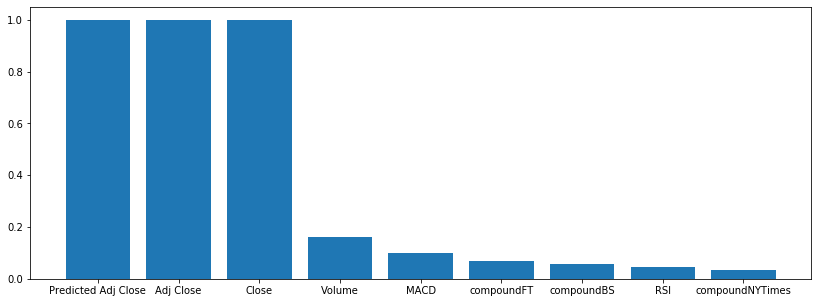

In [33]:
#Plot the corelation of each feature with the Predicted Adj Close as a bar graph
FeatureImportance = pd.DataFrame(np.absolute(Data.corr()['Predicted Adj Close'])).sort_values(by=['Predicted Adj Close'], ascending=False)
plt.rcParams['figure.figsize'] = 14, 5 
plt.bar(FeatureImportance.index, FeatureImportance['Predicted Adj Close'])
plt.show()